# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

2022-01-01 11:26:40.182097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-01 11:26:40.182128: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


### for SH events prediction pre processing


In [4]:
y_label = 'Pt_SevHypoEver' 
# possible labels Pt_SevHypoEver, SHSeizComaPast12mos, DKAPast12mos, Depression, DiabNeuro, DKADiag

In [5]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['Pt_SevHypoEver'])):
        if(row['NumSHSeizComaPast12mos'] >= 1) or (row['Pt_v3NumSHSeizComa'] >= 1) or (row['SHSeizComaPast12mos'] == 0):
            row['Pt_SevHypoEver'] = 0
        else:
            row['Pt_SevHypoEver'] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [6]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

print(df[y_label].unique())
get_possible_vals_with_nan(df, y_label)

# if(y_label == 'SHSeizComaPast12mos' ):
# #     df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa','NumSHSeizComa', 'Pt_SevHypoEver'], inplace=True, axis=1) # add SHSeizComaPast12mos
#     df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa'], inplace=True, axis=1) # add SHSeizComaPast12mos
#     df[y_label] = df[y_label].replace({2.0: 1.0})

if (y_label == 'Pt_SevHypoEver'):
#     df.drop(['NumSHSeizComaPast12mos','Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1) # add SHSeizComaPast12mos
    df[y_label] = df[y_label].replace({2.0: 0.0})


[1. 0. 2.]


In [7]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_GlutFreeDiet', 'Pt_CeliacDr', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'ReqInsulinCrit', 'DKADiag', 'OralAgnTrt', 'ExamDaysFromConsent', 'Gender', 'Weight', 'Height', 'BldPrSys', 'BldPrDia', 'InsulinDeliv', 'Lypohyper', 'Lipoatrophy', 'AcanNigrDiag', 'PulseRate', 'AcanNigrP

In [8]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsHumalog,Pt_InsNovolog,Pt_InsApidra,Pt_InsRegular,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
0,3963.0,1.0,1.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,12505.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
5,3100.0,2.0,1.0,1.0,0.0,1.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.9514,11.0
7,26063.0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,553.0,0.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,13365.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,15799.0,3.0,1.0,2.0,0.0,1.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,15966.0,0.0,1.0,1.0,0.0,0.0,NaN,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,6426.0,1.0,1.0,0.0,1.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,10659.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0


# Divide Dataset

In [9]:
df=df.drop('PtID', axis = 1)

In [10]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [11]:
Y.unique()

array([1., 0.])

# Feature Selection

In [12]:
shape = np.shape(X) 
feature = 25 #shape[1] 
n_classes = 2



In [13]:

seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=123)
# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [14]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [1445 3563]
Test -  [0. 1.] [ 619 1528]


# Imputations

<AxesSubplot:>

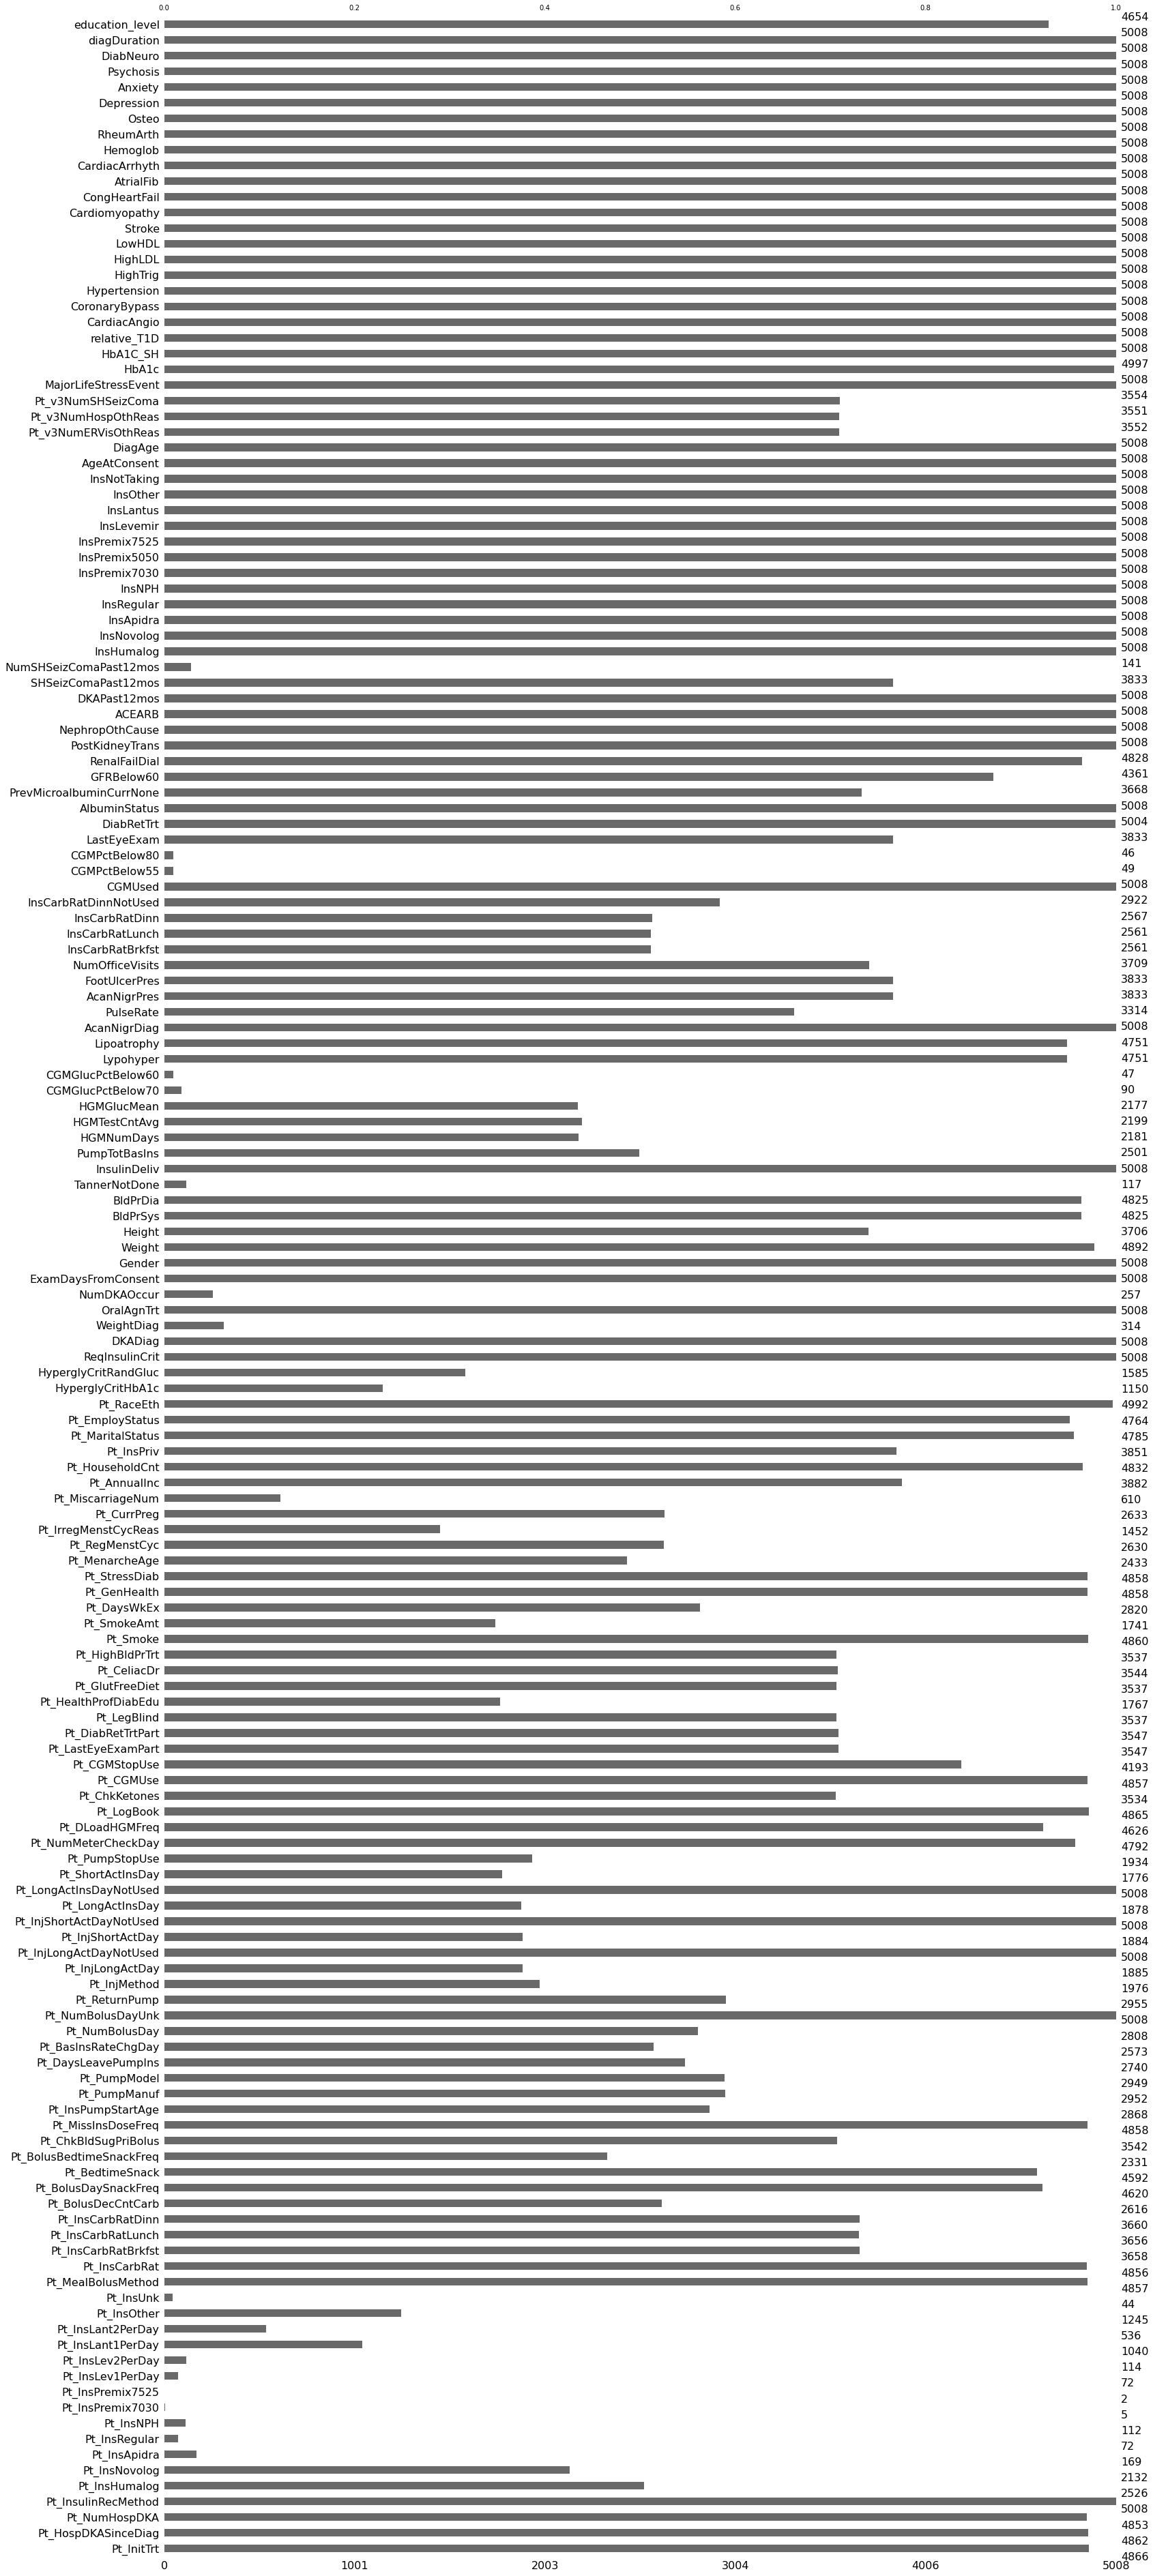

In [15]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

Cross Validation accuracy scores: [0.74051896 0.77644711 0.75648703 0.75848303 0.74251497 0.77644711
 0.78443114 0.73253493 0.756      0.786     ]
Cross Validation accuracy: 0.761 +/- 0.018

 
 ===========   Train Dataset    =============
84.0055910543131


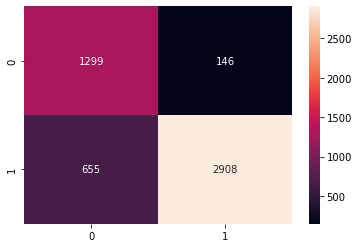

              precision    recall  f1-score   support

         0.0       0.66      0.90      0.76      1445
         1.0       0.95      0.82      0.88      3563

    accuracy                           0.84      5008
   macro avg       0.81      0.86      0.82      5008
weighted avg       0.87      0.84      0.85      5008

Accuracy of XGB on training set: 0.88


 ===========   Test Dataset    =============
74.28970656730321
              precision    recall  f1-score   support

         0.0       0.54      0.76      0.63       619
         1.0       0.88      0.73      0.80      1528

    accuracy                           0.74      2147
   macro avg       0.71      0.75      0.72      2147
weighted avg       0.78      0.74      0.75      2147



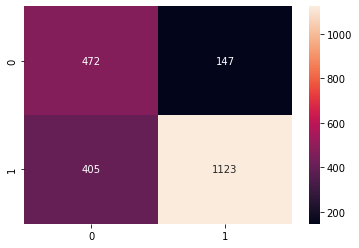

Accuracy of XGB classifier on test set: 0.77


 ===========   ROC    =============
roc_auc = 0.8342


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.76252019 0.73494764]
average accuracy:  0.7487339189200619


In [16]:
# xgboost - train with missing values

X_train_copy = X_train.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos', 'Pt_v3NumSHSeizComa'], axis=1)
X_test_copy = X_test.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos', 'Pt_v3NumSHSeizComa'], axis=1)




model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
#         n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )
                   
model.fit(X_train_copy,Y_train)

# cross validation
scores = cross_val_score(model, X=X_train_copy, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


xgb_pred=model.predict(X_test_copy)
xgb_pred_train=model.predict(X_train_copy)


xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= 0.81).astype(int)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= 0.81).astype(int)




print("\n \n ===========   Train Dataset    =============")

print(accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, xgb_pred_train))

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")



print(accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')



print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy: ', acc)
print('average accuracy: ',  np.sum(acc)/2)




<AxesSubplot:>

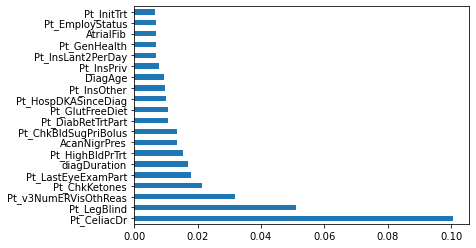

In [17]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:162])
feat_importances.nlargest(20).plot(kind='barh')

In [18]:


X_train.update(X_train[[
             'Pt_InsPriv', 'Pt_InsHumalog', 'Pt_InsNovolog','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone','Pt_InsApidra',
             'Pt_InsRegular','Pt_InsNPH','Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay',
             'Pt_InsOther',]].fillna(0))

X_test.update(X_test[[
             'Pt_InsPriv', 'Pt_InsHumalog', 'Pt_InsNovolog','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
             'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone','Pt_InsApidra',
             'Pt_InsRegular','Pt_InsNPH','Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay',
             'Pt_InsOther',]].fillna(0))

/usr/lib/python3/dist-packages/pandas/core/frame.py:6397: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = expressions.where(mask, this, that)


In [19]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')
# imputeX = IterativeImputer(max_iter=5, random_state=0)

X_train = imputeX.fit_transform(X_train)


In [20]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)



# Scale data

In [21]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
select[0] = pd.DataFrame(scaler.fit_transform(X_train))
select[1] = Y_train
select[2] = pd.DataFrame(scaler.transform(X_test))


## Feature Selection

In [22]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [23]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])
        
    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [24]:
# Feature selection
selected, fs, idx = select_features(select, feature)


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:31:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:32:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:33:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:34:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:03] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:07] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:40] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:35:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:06] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/kali/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:36:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)

Index(['Pt_InitTrt', 'Pt_HospDKASinceDiag', 'Pt_InsLant2PerDay',
       'Pt_ChkBldSugPriBolus', 'Pt_PumpManuf', 'Pt_NumBolusDayUnk',
       'Pt_LongActInsDay', 'Pt_ChkKetones', 'Pt_LastEyeExamPart',
       'Pt_DiabRetTrtPart', 'Pt_HighBldPrTrt', 'Pt_DaysWkEx', 'Pt_MenarcheAge',
       'HGMGlucMean', 'AcanNigrDiag', 'PulseRate', 'FootUlcerPres',
       'NumOfficeVisits', 'InsCarbRatDinnNotUsed', 'DKAPast12mos',
       'SHSeizComaPast12mos', 'DiagAge', 'Pt_v3NumERVisOthReas',
       'Pt_v3NumSHSeizComa', 'diagDuration'],
      dtype='object')
(7155, 25)


In [26]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [27]:
# X_train.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)
# X_test.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)

if('SHSeizComaPast12mos' in X_train.columns):
    X_train = X_train.drop(['SHSeizComaPast12mos'], axis=1)
    X_test = X_test.drop(['SHSeizComaPast12mos'], axis=1)
if('NumSHSeizComaPast12mos' in X_train.columns):
    X_train = X_train.drop(['NumSHSeizComaPast12mos'], axis=1)
    X_test = X_test.drop([ 'NumSHSeizComaPast12mos'], axis=1)
if('Pt_v3NumSHSeizComa' in X_train.columns):
    X_train = X_train.drop(['Pt_v3NumSHSeizComa'], axis=1)
    X_test = X_test.drop(['Pt_v3NumSHSeizComa'], axis=1)


Cross Validation accuracy scores: [0.71057884 0.76047904 0.76447106 0.74850299 0.73453094 0.74451098
 0.78243513 0.72854291 0.752      0.772     ]
Cross Validation accuracy: 0.750 +/- 0.020

 
 ===========   Train Dataset    =============
76.37779552715655


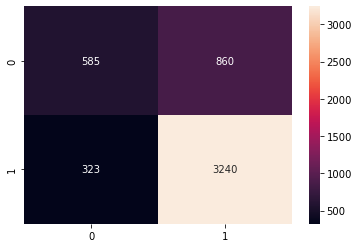

              precision    recall  f1-score   support

         0.0       0.64      0.40      0.50      1445
         1.0       0.79      0.91      0.85      3563

    accuracy                           0.76      5008
   macro avg       0.72      0.66      0.67      5008
weighted avg       0.75      0.76      0.75      5008

Accuracy of adaboost on training set: 0.76


 ===========   Test Dataset    =============
74.70889613414066


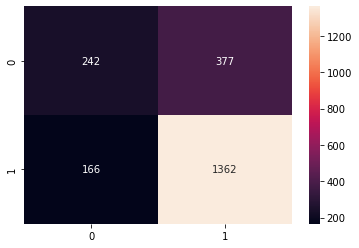

              precision    recall  f1-score   support

         0.0       0.59      0.39      0.47       619
         1.0       0.78      0.89      0.83      1528

    accuracy                           0.75      2147
   macro avg       0.69      0.64      0.65      2147
weighted avg       0.73      0.75      0.73      2147

Accuracy of adaboost classifier on test set: 0.75


 ===========   ROC    =============
roc_auc = 0.7927


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.39095315 0.89136126]
average accuracy:  0.6411572033934145


In [46]:

adaboost = AdaBoostClassifier(random_state=0, learning_rate=0.05, n_estimators=1000, algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# cross validation
scores = cross_val_score(adaboost, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

adaboost.fit(X_train, Y_train)
# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

pred = (adaboost.predict_proba(X_test)[:,1] >= 0.5).astype(int)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= 0.5).astype(int)


print("\n \n ===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_ada_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_ada_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = adaboost.score(X_train, Y_train)
print('Accuracy of adaboost on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")

print(accuracy_score(Y_test, pred)*100)

confusion_matrix_ada = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_ada, annot=True,fmt='g')
plt.show()

print(classification_report(Y_test, pred))
test_acc = adaboost.score(X_test, Y_test)
print('Accuracy of adaboost classifier on test set: {:.2f}'
     .format(test_acc))


# ROC

print("\n\n ===========   ROC    =============")

y_scores = adaboost.predict_proba(X_test)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_ada.diagonal()/confusion_matrix_ada.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))


<AxesSubplot:>

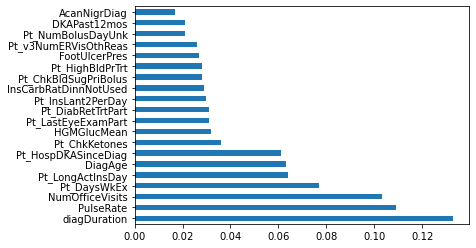

In [29]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Cross Validation accuracy scores: [0.750499   0.75449102 0.78842315 0.74451098 0.74051896 0.75848303
 0.79840319 0.74251497 0.758      0.76      ]
Cross Validation accuracy: 0.760 +/- 0.018

 
 ===========   Train Dataset    =============
80.27156549520767


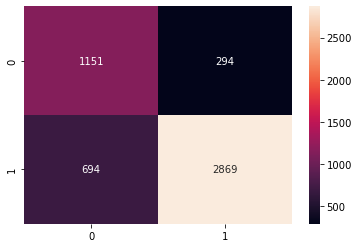

              precision    recall  f1-score   support

         0.0       0.62      0.80      0.70      1445
         1.0       0.91      0.81      0.85      3563

    accuracy                           0.80      5008
   macro avg       0.77      0.80      0.78      5008
weighted avg       0.83      0.80      0.81      5008

Accuracy of XGB on training set: 0.83


 ===========   Test Dataset    =============
74.28970656730321
              precision    recall  f1-score   support

         0.0       0.54      0.70      0.61       619
         1.0       0.86      0.76      0.81      1528

    accuracy                           0.74      2147
   macro avg       0.70      0.73      0.71      2147
weighted avg       0.77      0.74      0.75      2147



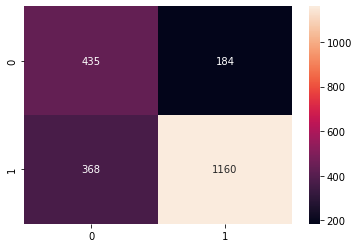

Accuracy of XGB classifier on test set: 0.75


 ===========   ROC    =============
roc_auc = 0.8118


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.70274637 0.7591623 ]
average accuracy:  0.7309543343849647


In [30]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
xgb_impute.fit(X_train,Y_train)

# cross validation
scores = cross_val_score(xgb_impute, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= 0.81).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= 0.81).astype(int)


print("\n \n ===========   Train Dataset    =============")

print(accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, xgb_pred_train))

train_acc = xgb_impute.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")



print(accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')
print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = xgb_impute.score(X_test, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC

print("\n\n ===========   ROC    =============")

y_scores = xgb_impute.predict_proba(X_test)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')

print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))


<AxesSubplot:>

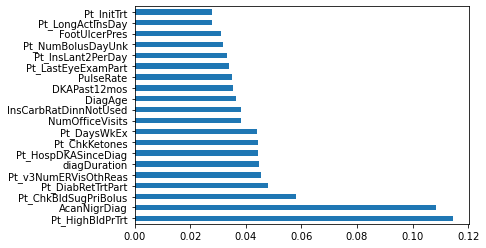

In [31]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Cross Validation accuracy scores: [0.69261477 0.73852295 0.74051896 0.71457086 0.69461078 0.76247505
 0.75848303 0.69860279 0.692      0.696     ]
Cross Validation accuracy: 0.719 +/- 0.027
===========   Train Dataset    =============
80.61102236421725


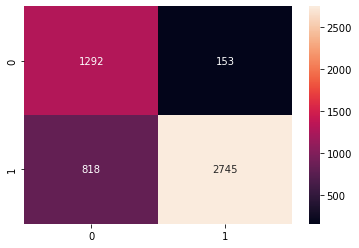

              precision    recall  f1-score   support

         0.0       0.61      0.89      0.73      1445
         1.0       0.95      0.77      0.85      3563

    accuracy                           0.81      5008
   macro avg       0.78      0.83      0.79      5008
weighted avg       0.85      0.81      0.81      5008

Accuracy of XGB on training set: 0.81


 ===========   Test Dataset    =============
72.98556124825338
              precision    recall  f1-score   support

         0.0       0.52      0.76      0.62       619
         1.0       0.88      0.72      0.79      1528

    accuracy                           0.73      2147
   macro avg       0.70      0.74      0.71      2147
weighted avg       0.78      0.73      0.74      2147



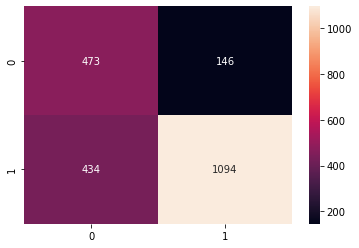

Accuracy of random forest classifier classifier on test set: 0.73


 ===========   ROC    =============
roc_auc = 0.8164


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.7641357  0.71596859]
average accuracy:  0.7400521445668998


In [32]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=10,
#                              n_estimators = feature,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.001,
                             random_state=0)

# cross validation
scores = cross_val_score(rf, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


rf.fit(X_train,Y_train)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= 0.5).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= 0.5).astype(int)


print("===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_rfc_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_rfc_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = rf.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")


print(accuracy_score(Y_test, pred)*100)

confusion_matrix_rf = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_rf, annot=True, fmt='g')

print(classification_report(Y_test, pred))
plt.show()

test_acc = rf.score(X_test, Y_test)
print('Accuracy of random forest classifier classifier on test set: {:.2f}'
     .format(test_acc))


# ROC

print("\n\n ===========   ROC    =============")

y_scores = rf.predict_proba(X_test)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')

# fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_scores[:,1])


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_rf.diagonal()/confusion_matrix_rf.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

<AxesSubplot:>

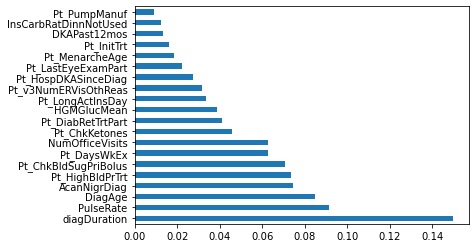

In [33]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 3 LogisticRegression

/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "
/home/kali/.local/li

Cross Validation accuracy scores: [0.69860279 0.69461078 0.71656687 0.71257485 0.67265469 0.70658683
 0.72654691 0.70858283 0.722      0.706     ]
Cross Validation accuracy: 0.706 +/- 0.015

 
 ===========   Train Dataset    =============
70.7667731629393


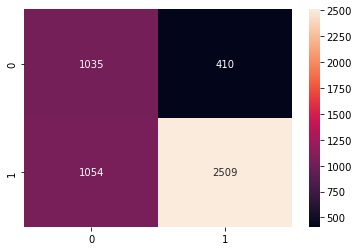

              precision    recall  f1-score   support

         0.0       0.50      0.72      0.59      1445
         1.0       0.86      0.70      0.77      3563

    accuracy                           0.71      5008
   macro avg       0.68      0.71      0.68      5008
weighted avg       0.75      0.71      0.72      5008

Accuracy of LR on training set: 0.71


 ===========   Test Dataset    =============
70.37727061015372
              precision    recall  f1-score   support

         0.0       0.49      0.73      0.59       619
         1.0       0.86      0.69      0.77      1528

    accuracy                           0.70      2147
   macro avg       0.68      0.71      0.68      2147
weighted avg       0.76      0.70      0.72      2147



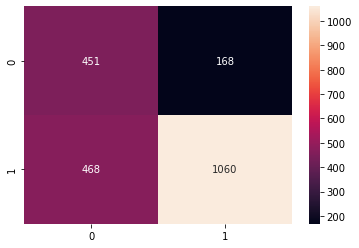

Accuracy of logistic regression on test set: 0.70


 ===========   ROC    =============
roc_auc = 0.773


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.72859451 0.69371728]
average accuracy:  0.7111558923783505


In [49]:

#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# cross validation
scores = cross_val_score(logreg, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

logreg.fit(X_train, Y_train)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

pred = (logreg.predict_proba(X_test)[:,1] >= 0.5).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= 0.5).astype(int)

# proba = logreg.predict_proba(X_test)


# for i,val in enumerate(proba):
#     print(proba[i], pred[i], Y_test.to_numpy()[i] )

print("\n \n ===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_lg_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_lg_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = logreg.score(X_train, Y_train)
print('Accuracy of LR on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")

print(accuracy_score(Y_test, pred)*100)

confusion_matrix_lr = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_lr, annot=True, fmt='g')

print(classification_report(Y_test, pred))
plt.show()

test_acc = logreg.score(X_test, Y_test)
print('Accuracy of logistic regression on test set: {:.2f}'
     .format(test_acc))



# ROC

print("\n\n ===========   ROC    =============")

y_scores = logreg.predict_proba(X_test)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_lr.diagonal()/confusion_matrix_lr.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

<AxesSubplot:>

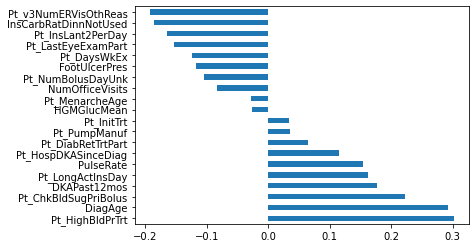

In [35]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 4 - Decision tree

Cross Validation accuracy scores: [0.6247505  0.68063872 0.69660679 0.68463074 0.70459082 0.69660679
 0.70658683 0.70858283 0.708      0.674     ]
Cross Validation accuracy: 0.688 +/- 0.024

 
===========   Train Dataset    =============
100.0


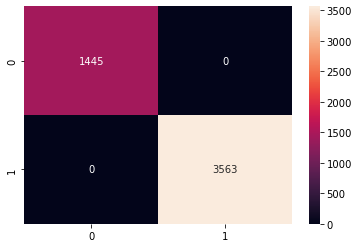

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1445
         1.0       1.00      1.00      1.00      3563

    accuracy                           1.00      5008
   macro avg       1.00      1.00      1.00      5008
weighted avg       1.00      1.00      1.00      5008

Accuracy of XGB on training set: 1.00


 ===========   Test Dataset    =============
68.88681881695389
              precision    recall  f1-score   support

         0.0       0.46      0.47      0.46       619
         1.0       0.78      0.78      0.78      1528

    accuracy                           0.69      2147
   macro avg       0.62      0.62      0.62      2147
weighted avg       0.69      0.69      0.69      2147



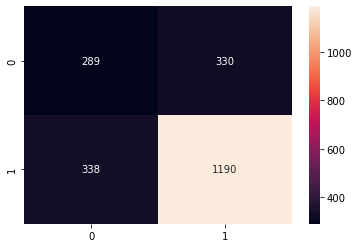

Accuracy of DT on test set: 0.69


 ===========   ROC    =============
roc_auc = 0.6228


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.46688207 0.77879581]
average accuracy:  0.6228389396848488


In [52]:
clf = DecisionTreeClassifier(
                        random_state=0,
                        criterion='gini',
                        splitter = 'best',
                        max_depth = 100,
                        max_features = 20).fit(X_train, Y_train)

# cross validation
scores = cross_val_score(clf, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))


# pred=clf.predict(X_test)
# pred_train=clf.predict(X_train)

pred = (clf.predict_proba(X_test)[:,1] >= 0.75).astype(int)
pred_train = (clf.predict_proba(X_train)[:,1] >= 0.75).astype(int)

print("\n \n===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_dt_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_dt_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = clf.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")

print(accuracy_score(Y_test, pred)*100)

confusion_matrix_dt =confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_dt, annot=True, fmt='g')

print(classification_report(Y_test, pred))
plt.show()

test_acc = clf.score(X_test, Y_test)
print('Accuracy of DT on test set: {:.2f}'.format(test_acc))


# ROC
print("\n\n ===========   ROC    =============")

y_scores = clf.predict_proba(X_test)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')

print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_dt.diagonal()/confusion_matrix_dt.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

In [ ]:

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 5 - K-Nearest Neighbors

Cross Validation accuracy scores: [0.67065868 0.66267465 0.68862275 0.66267465 0.67864271 0.72255489
 0.69660679 0.73053892 0.706      0.672     ]
Cross Validation accuracy: 0.689 +/- 0.023
===========   Train Dataset    =============
100.0


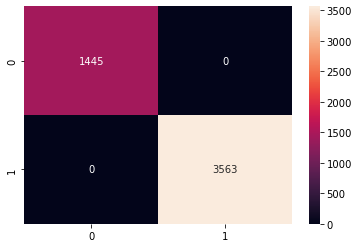

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1445
         1.0       1.00      1.00      1.00      3563

    accuracy                           1.00      5008
   macro avg       1.00      1.00      1.00      5008
weighted avg       1.00      1.00      1.00      5008

Accuracy of XGB on training set: 1.00


 ===========   Test Dataset    =============
69.11970190964136
              precision    recall  f1-score   support

         0.0       0.46      0.47      0.46       619
         1.0       0.78      0.78      0.78      1528

    accuracy                           0.69      2147
   macro avg       0.62      0.62      0.62      2147
weighted avg       0.69      0.69      0.69      2147



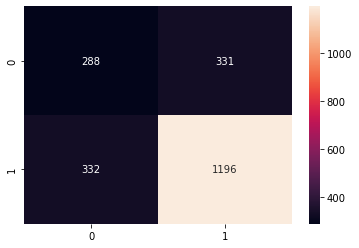

Accuracy of KNN on test set: 0.69


 ===========   ROC    =============
roc_auc = 0.624


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.46526656 0.78272251]
average accuracy:  0.6239945360275397


In [53]:
knn = KNeighborsClassifier(
    n_neighbors =1,
    weights = "uniform", # uniform, distance
    algorithm =  'brute', # {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
)

# cross validation
scores = cross_val_score(knn, X=X_train, y=Y_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores)
print('Cross Validation accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

knn.fit(X_train, Y_train)


# pred=knn.predict(X_test)
# pred_train=knn.predict(X_train)
pred = (knn.predict_proba(X_test)[:,1] >= 0.6).astype(int)
pred_train = (knn.predict_proba(X_train)[:,1] >= 0.6).astype(int)

print("===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_dt_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_dt_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = knn.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")

print(accuracy_score(Y_test, pred)*100)

confusion_matrix_knn = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_knn, annot=True, fmt='g')
print(classification_report(Y_test, pred))
plt.show()

test_acc = knn.score(X_test, Y_test)
print('Accuracy of KNN on test set: {:.2f}'.format(test_acc))


# ROC
print("\n\n ===========   ROC    =============")

y_scores = knn.predict_proba(X_test)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')

print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_knn.diagonal()/confusion_matrix_knn.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

## Model 6 - Linear Discriminant Analysis

===========   Train Dataset    =============
73.76198083067092


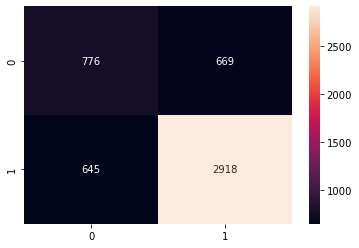

              precision    recall  f1-score   support

         0.0       0.55      0.54      0.54      1445
         1.0       0.81      0.82      0.82      3563

    accuracy                           0.74      5008
   macro avg       0.68      0.68      0.68      5008
weighted avg       0.74      0.74      0.74      5008

Accuracy of XGB on training set: 0.75


 ===========   Test Dataset    =============
73.59105728924081
              precision    recall  f1-score   support

         0.0       0.54      0.55      0.54       619
         1.0       0.82      0.81      0.81      1528

    accuracy                           0.74      2147
   macro avg       0.68      0.68      0.68      2147
weighted avg       0.74      0.74      0.74      2147



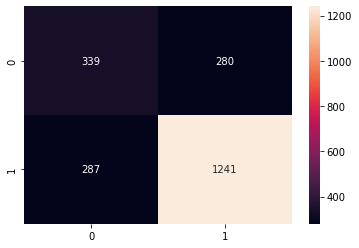

Accuracy of LDA on test set: 0.75


 ===========   ROC    =============
roc_auc = 0.7738


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.54765751 0.81217277]
average accuracy:  0.6799151434927133


In [54]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
lda.fit(X_train, Y_train)


# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

pred = (lda.predict_proba(X_test)[:,1] >= 0.61).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= 0.61).astype(int)

print("===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_dt_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_dt_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = lda.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")


print(accuracy_score(Y_test, pred)*100)

confusion_matrix_lda = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_lda, annot=True, fmt='g')
print(classification_report(Y_test, pred))
plt.show()

test_acc = lda.score(X_test, Y_test)
print('Accuracy of LDA on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = lda.predict_proba(X_test)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_lda.diagonal()/confusion_matrix_lda.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

## Model 7- Gaussian Naive Bayes

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.2848035868435802)
===========   Train Dataset    =============
72.72364217252397


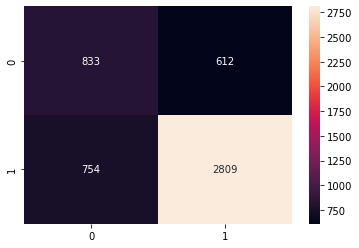

              precision    recall  f1-score   support

         0.0       0.52      0.58      0.55      1445
         1.0       0.82      0.79      0.80      3563

    accuracy                           0.73      5008
   macro avg       0.67      0.68      0.68      5008
weighted avg       0.74      0.73      0.73      5008

Accuracy of XGB on training set: 0.74


 ===========   Test Dataset    =============
72.51979506287843
              precision    recall  f1-score   support

         0.0       0.52      0.60      0.56       619
         1.0       0.83      0.78      0.80      1528

    accuracy                           0.73      2147
   macro avg       0.67      0.69      0.68      2147
weighted avg       0.74      0.73      0.73      2147



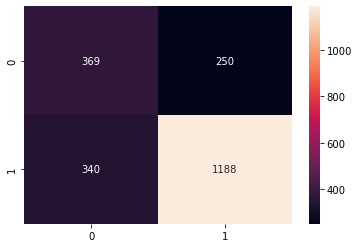

Accuracy of gaussian naive bayes on test set: 0.73


 ===========   ROC    =============
roc_auc = 0.7681


 ===========   Class-wise test accuracy    =============
classwise accuracy:  [0.59612278 0.77748691]
average accuracy:  0.6868048448350236


In [43]:



gnb = GaussianNB()

param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

nbModel_grid = GridSearchCV(estimator=gnb, param_grid=param_grid_nb, verbose=1, cv=10, n_jobs=-1)
nbModel_grid.fit(X_train, Y_train)

# best parameters
print(nbModel_grid.best_estimator_)

gnb = GaussianNB(priors=None, var_smoothing=1.0)
gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)

# pred_train=gnb.predict(X_train)

pred = (gnb.predict_proba(X_test)[:,1] >= 0.81).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= 0.81).astype(int)

print("===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_dt_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_dt_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = gnb.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")


print(accuracy_score(Y_test, pred)*100)

confusion_matrix_gnb = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_gnb, annot=True, fmt='g')
print(classification_report(Y_test, pred))
plt.show()

test_acc = gnb.score(X_test, Y_test)
print('Accuracy of gaussian naive bayes on test set: {:.2f}'.format(test_acc))


# ROC
print("\n\n ===========   ROC    =============")

y_scores = gnb.predict_proba(X_test)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_gnb.diagonal()/confusion_matrix_gnb.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

## Model 8 - SVM

In [44]:

# svm = SVC(
#     C = 10, # Cfloat, default=1.0
#     kernel = 'sigmoid', #kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
#     degree = 5, #degree, default=3
#     gamma = 0.1, #gamma{‘scale’, ‘auto’} or float, default=’scale’
#     class_weight = None, # ‘balanced’, default=None
#     max_iter = 15,
# #     decision_function_shape = 'ovo' # {‘ovo’, ‘ovr’}, default=’ovr’
# )

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree': [0,1,2,3],
              'max_iter': [10,15,20],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, Y_train)

# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

svm = SVC(C = grid.best_params_['C'],
         gamma = grid.best_params_['gamma'],
         degree = grid.best_params_['degree'],
         max_iter = grid.best_params_['max_iter'],
         kernel = grid.best_params_['kernel']
         )

svm.fit(X_train, Y_train)

# pred=svm.predict(X_test)
# pred_train=svm.predict(X_train)

pred = (svm.predict_proba(X_test)[:,1] >= 0.81).astype(int)
pred_train = (svm.predict_proba(X_train)[:,1] >= 0.81).astype(int)

print("===========   Train Dataset    =============")

print(accuracy_score(Y_train, pred_train)*100)

confusion_matrix_dt_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
sns.heatmap(confusion_matrix_dt_train, annot=True,fmt='g')
plt.show()

print(classification_report(Y_train, pred_train))

train_acc = svm.score(X_train, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print(accuracy_score(Y_test, pred)*100)

confusion_matrix_svm = confusion_matrix(Y_test, pred)
sns.heatmap(confusion_matrix_svm, annot=True, fmt='g')
print(classification_report(Y_test, pred))
plt.show()

test_acc = svm.score(X_test, Y_test)
print('Accuracy of svm on test set: {:.2f}'.format(test_acc))


# ROC
print("\n\n ===========   ROC    =============")

y_scores = svm.predict_proba(X_test)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_svm.diagonal()/confusion_matrix_svm.sum(axis=1)
print('classwise accuracy: ',(acc))
print('average accuracy: ',( np.sum(acc)/2))

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 1/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.287 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.294 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.290 total time=   0.1s
[CV 5/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.298 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.290 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.1s
[CV 3/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.1s
[CV 4/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.292 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 5/5] END C=0.1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.301 total time=   0.1s
[CV 1/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.381 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.527 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.420 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.442 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.314 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.500 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.603 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.497 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.403 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.506 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.527 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.628 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.479 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.430 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.506 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.660 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.716 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.697 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.686 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.718 total time=   0.1s
[CV 3/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.710 total time=   0.1s
[CV 4/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.715 total time=   0.1s
[CV 5/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.696 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.652 total time=   0.1s
[CV 2/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.722 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.700 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.705 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.702 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 4/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 5/5] END C=0.1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.718 total time=   0.0

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 3/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.713 total time=   0.1s
[CV 4/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.536 total time=   0.1s
[CV 5/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 1/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.1s
[CV 2/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.713 total time=   0.1s

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 3/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.1s
[CV 4/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.703 total time=   0.1s
[CV 5/5] END C=0.1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.714 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.708 total time=   0.1s
[CV 2/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.287 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.294 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.290 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.298 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=1, k

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.292 total time=   0.1s
[CV 5/5] END C=0.1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.301 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.381 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.527 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.420 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.442 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.314 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.500 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.603 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.497 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.403 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.506 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.527 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.628 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.479 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.430 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.506 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.660 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.716 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 5/5] END C=0

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.696 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.652 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.722 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.700 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.705 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.699 total time=   0.1s
[CV 4/5

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.1s
[CV 3/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.1s
[CV 4/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.702 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.718 total time=   0.0s
[CV 3/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.701 total time=   0.0s
[CV 4/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.634 total time=   0.0s
[CV 5/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.705 total time=  

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 1/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.1s
[CV 2/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.713 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.1s
[CV 4/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.703 total time=   0.1s
[CV 5/5] END C=0.1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.714 total time=   0.1s
[CV 1/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.1s
[CV 3/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.287 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.294 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.290 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.298 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.290 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=1, k

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 5/5] END C=0.1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.301 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.381 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.527 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.420 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.442 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.314 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.500 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.603 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.497 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.403 total time=   0.0s
[CV 5/5] END C=0.1, d

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.479 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.430 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.506 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.660 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.716 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.697 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.686 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.718 total time=   0.0s
[CV 3/5] END 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.722 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.700 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.705 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.718 total time=   0.0s
[CV 3/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.701 total time=   0.0s
[CV 4/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.634 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.705 total time=  

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 2/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.1s
[CV 3/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.713 total time=   0.1s
[CV 4/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.536 total time=   0.0s
[CV 5/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.1s
[CV 1/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.713 total time=   0.1s
[CV 3/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.1s
[CV 4/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.703 total time=   0.1s
[CV 5/5] END C=0.1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.714 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.708 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.287 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.294 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.290 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.298 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=1, k

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.292 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.301 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.381 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.527 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.420 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.442 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.314 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.500 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.603 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.497 total time=   0.0s
[CV 4/5] END C=0.1, degr

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.430 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.506 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.660 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.716 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.697 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.686 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.718 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 4/5] END

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.695 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.705 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.1s
[CV 3/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.702 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.1s
[CV 2/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.1s
[CV 3/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.718 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.701 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.634 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.536 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 1/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 3/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 4/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.703 total time=   0.0s
[CV 5/5] END C=0.1, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.714 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.709 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.299 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.703 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.481 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.552 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.367 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.408 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.363 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.466 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.581 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.451 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.660 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.686 total time=   0.1s
[CV 2/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.718 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.719 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.652 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.700 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.693 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.705 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 3/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 3/5] END C=1, d

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.718 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.701 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.634 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 2/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 3/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s
[CV 4/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.536 total time=   0.0s
[CV 5/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 1/5] END C=1, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.713 total time=   0.1s
[CV 4/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.300 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.289 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.717 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.709 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.299 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.703 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 4/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.511 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.307 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.494 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.503 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.474 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.676 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.367 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.408 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.363 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.466 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.1, 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.691 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.686 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.718 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.719 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.652 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 3/5] END C=1, degree=1, ga

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 3/5] END C=1, de

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.634 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s
[CV 4/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.536 total time=   0.0s
[CV 5/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 1/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 4/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.300 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.289 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.717 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.705 total time=   0.1s
[CV 5/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.709 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.299 total time=   0.1s
[CV 2/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.1s
[CV 3/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.703 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.481 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.552 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.511 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.307 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.494 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.503 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.474 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.676 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.367 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.408 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.363 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.466 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.581 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.451 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.01, 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 2/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.718 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.719 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.652 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.700 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.693 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.705 total time=   0.0s
[CV 2/5] END C=1, degree=2, 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.1s
[CV 2/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.1s
[CV 4/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.718 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.701 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.634 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 3/5] END 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 4/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.703 total time=   0.0s
[CV 5/5] END C=1, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.714 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.300 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=1

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 1/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.299 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.703 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.481 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.552 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.511 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.307 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.1, kernel=rbf

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.676 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.367 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.408 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.363 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.466 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.581 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.451 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.660 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.0

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.718 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.719 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.652 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.700 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=1, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.693 total time=   0.1s
[CV 1/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.705 total time=   0.1s
[CV 2/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.699 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 5/5] END C=1, de

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.701 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.634 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 3/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s
[CV 4/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.536 total time=   0.0s
[CV 5/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 1/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=1, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 3/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.302 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.291 total time=   0.1s
[CV 5/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.302 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.302 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.338 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.305 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.430 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.1, kern

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.369 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.347 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.531 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.422 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.510 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.310 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.388 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.454 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.433 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.526 total time=   0.0s
[CV 5/5] END C=10, degree=0, g

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.719 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.696 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 4/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.689 total time=   0.1s
[CV 5/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.695 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.700 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.721 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.686 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.684 total time=   0.0s
[CV 4/5] END C=10

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 4/5

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.720 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.445 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 1/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.664 total time=   0.0s
[CV 3/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 4/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.699 total time=   0.0s
[CV 5/5] END C=10, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.714 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 3/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.488 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.369 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.347 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.531 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.422 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.510 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.310 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.388 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.454 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.433 total time=   0.0s
[CV 4/5] END C=10, degree=1, g

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=10, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.440 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.668 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.719 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.696 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.689 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.695 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.700 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.721 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.686 total time=   0.0s
[CV 1/5] END C=10, d

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.1s
[CV 4/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.1s
[CV 1/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.1s
[CV 2/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.710 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


[CV 3/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.1s
[CV 4/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.1s
[CV 5/5] END C=10, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.1s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.1s
[CV 2/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.710 total time=   0.1s
[CV 5/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 2/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.611 total time=   0.0s
[CV 3/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.720 total time=   0.0s
[CV 4/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.445 total time=   0.0s
[CV 5/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 1/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.664 total time=   0.1s
[CV 3/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.708 total time=   0.1s
[CV 4/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.699 total time=   0.1s
[CV 5/5] END C=10, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.714 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.302 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.291 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.302 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=1, kernel=rbf, 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.302 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.338 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.305 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.430 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.488 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.369 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.347 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.531 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.422 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.454 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.433 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.526 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.440 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.668 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.719 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 2/5] END C=10, degre

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.701 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.700 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.721 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.686 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.684 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 1/5] END C=

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.703 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.710 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.704 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 4/5

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.445 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 1/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.664 total time=   0.0s
[CV 3/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 4/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.699 total time=   0.0s
[CV 5/5] END C=10, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.714 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 4/5] END C=

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.291 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.302 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.302 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.338 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.1, kernel=r

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.531 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.422 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.510 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.310 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.388 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.454 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.433 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.526 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=10, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.440 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.668 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.719 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.698 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.708 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.696 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.689 total time=   0.0s
[CV 5/5] END C=10, de

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.721 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.686 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.694 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.684 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.713 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 4/5] END

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.709 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.659 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.703 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.715 total time=   0.0s
[CV 2/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.611 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.720 total time=   0.0s
[C

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.664 total time=   0.0s
[CV 3/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.708 total time=   0.0s
[CV 4/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.699 total time=   0.0s
[CV 5/5] END C=10, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.714 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.302 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=100, degr

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.302 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.302 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.415 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.305 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.430 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.488 total time=   0.0s
[CV 5/5] END C=100, degree=0, ga

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.369 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.392 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.433 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.400 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.509 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.365 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.607 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.565 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.609 total time=   0.0s
[CV 5/5] END C=1

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.644 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.518 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.569 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.534 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.592 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.542 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.573 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.693 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 3/5]

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.588 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.621 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.658 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.625 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.684 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.652 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.688 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.624 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.718 total time=   0.

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 1/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.650 total time=   0.0s
[CV 2/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 3/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.716 total time=   0.0s
[CV 4/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.676 total time=   0.0s
[CV 5/5] END C=100, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.291 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.302 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.302 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.415 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=10;, score=0.305 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.338 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.478 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.422 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.493 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.369 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.392 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.433 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.400 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.509 total time=   0.0s
[CV 1/5] END C=100, 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.568 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.561 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.644 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.518 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.569 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.534 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.592 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.542 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.573 total time=   0.0s
[CV 1/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.702 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.640 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=10;, score=0.564 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.689 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.718 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.588 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.621 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.658 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 2/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.624 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.718 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 2/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.686 total time=   0.0s
[CV 3/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.716 total time=   0.0s
[CV 4/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 1/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.650 total ti

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.676 total time=   0.0s
[CV 5/5] END C=100, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.302 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=100, degree=2, 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 1/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.1s
[CV 3/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.302 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.415 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.305 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.430 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.488 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.338 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.478 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.422 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.493 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.369 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.392 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.433 total time=   0.0s
[CV 4/5] END C=100, 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.609 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.467 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.568 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.561 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.644 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.518 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.569 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.534 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.592 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 4/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.564 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.689 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.718 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.588 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.621 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.658 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.625 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.684 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.688 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.624 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.718 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 2/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.686 total time=   0.0s
[CV 3/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.716 total time=   0.0s
[CV 4/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.698 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.711 total tim

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 4/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.676 total time=   0.0s
[CV 5/5] END C=100, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.715 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.302 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=100, degree=3,

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 1/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.302 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.415 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.305 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.430 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.488 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 1/5] END C=100, degree=3,

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=100, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.509 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.365 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.607 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.565 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.609 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.467 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.568 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.561 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.644 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.518 total time=   0.0s
[CV 5/5] EN

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.592 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.542 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.573 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.693 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.702 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.640 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=10;, score=0.564 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.689 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.718 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.706 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.588 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.705 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.684 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.652 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.688 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.624 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.718 total time=   0.0s
[CV 4/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 5/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.712 total time=   0.0s
[CV 1/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.710 total time=   0.0s
[CV 2/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.686 total time=   0.0s
[CV 3/5] END C=100, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.716 total time=

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=10;, score=0.302 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.291 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=15;, score=0.302 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 4/5] END C=1000, degree=0,

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.305 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.430 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.488 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.338 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.478 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.422 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.493 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=15;, score=0.369 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.392 total time=   0.0s
[CV 2/5] E

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.400 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.1, kernel=rbf, max_iter=20;, score=0.509 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.365 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.607 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.565 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.623 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=10;, score=0.467 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.568 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.631 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=15;, score=0.644 total time=   0.0s
[C

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.554 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.591 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.01, kernel=rbf, max_iter=20;, score=0.564 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.675 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.691 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.696 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.672 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=10;, score=0.511 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.618 total time=  

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 5/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=15;, score=0.690 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.625 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.648 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.623 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.682 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.001, kernel=rbf, max_iter=20;, score=0.660 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.411 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.716 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.716 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.716 total

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 5/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.662 total time=   0.0s
[CV 1/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.670 total time=   0.0s
[CV 2/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 3/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.590 total time=   0.0s
[CV 4/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 5/5] END C=1000, degree=0, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.687 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.291 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=15;, score=0.302 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=1, kernel=rbf, max_iter=20;, score=0.302 total time=   0.0s
[CV 1/5] END C=1000, degree=1,

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 1/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.338 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.478 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.422 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.493 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=15;, score=0.369 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.392 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.433 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.400 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.1, kernel=rbf, max_iter=20;, score=0.509 total time=   0.0s
[CV 1/5] 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 1/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.568 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.631 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.644 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.622 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=15;, score=0.560 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.484 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.554 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.591 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.01, kernel=rbf, max_iter=20;, score=0.564 total time=   0.0s

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.668 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.655 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.346 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=15;, score=0.690 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.625 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.648 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.623 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.682 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.001, kernel=rbf, max_iter=20;, score=0.660 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.411 total ti

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 2/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.596 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.357 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.662 total time=   0.0s
[CV 1/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.670 total time=   0.0s
[CV 2/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 3/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.590 total time=   0.0s
[CV 4/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 5/5] END C=1000, degree=1, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.687 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=10;, score=0.710 tota

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.291 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=15;, score=0.302 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.712 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.711 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=1, kernel=rbf, max_iter=20;, score=0.302 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.415 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=10;, score=0.305 total time=   0.0s
[CV 3/5] END C=1000, degre

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.422 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.493 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=15;, score=0.369 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.392 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.433 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.400 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.1, kernel=rbf, max_iter=20;, score=0.509 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.365 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=10;, score=0.607 total time=   0.0s
[CV 3/5]

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 3/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.644 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.622 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=15;, score=0.560 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.484 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.554 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.591 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.01, kernel=rbf, max_iter=20;, score=0.564 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.675 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=10;, score=0.691 total time=   0.

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('


[CV 3/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.655 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.346 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=15;, score=0.690 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.625 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.648 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.623 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.682 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.001, kernel=rbf, max_iter=20;, score=0.660 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.411 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.716 total 

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.716 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=10;, score=0.620 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.653 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.596 total time=   0.0s
[CV 4/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.357 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.662 total time=   0.0s
[CV 1/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.670 total time=   0.0s
[CV 2/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 3/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.590

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 5/5] END C=1000, degree=2, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.687 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.711 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.291 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.710 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=10;, score=0.302 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.711 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=15;, score=0.712 total time=   0.0s
[CV 4/5] END C=1000,

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 3/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.713 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.298 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=1, kernel=rbf, max_iter=20;, score=0.302 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.415 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.305 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.430 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.488 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=10;, score=0.295 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.338 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.478 total time=   0.0s
[CV 3/5] END C=1

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 4/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.493 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=15;, score=0.369 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.392 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.395 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.433 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.400 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.1, kernel=rbf, max_iter=20;, score=0.509 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.365 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.607 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=10;, score=0.565 total time=   0.0s
[CV 4/5

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.568 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.631 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.644 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.622 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=15;, score=0.560 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.484 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.554 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.636 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.591 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.01, kernel=rbf, max_iter=20;, score=0.564 total time=   0.0s


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.618 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.668 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.655 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.346 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=15;, score=0.690 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.625 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.648 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.623 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.682 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.001, kernel=rbf, max_iter=20;, score=0.660 total tim

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

[CV 1/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.653 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.713 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.596 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.357 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=15;, score=0.662 total time=   0.0s
[CV 1/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.670 total time=   0.0s
[CV 2/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.706 total time=   0.0s
[CV 3/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.590 total time=   0.0s
[CV 4/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.709 total time=   0.0s
[CV 5/5] END C=1000, degree=3, gamma=0.0001, kernel=rbf, max_iter=20;, score=0.687

/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=15).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('

{'C': 0.1, 'degree': 0, 'gamma': 0.0001, 'kernel': 'rbf', 'max_iter': 20}
SVC(C=0.1, degree=0, gamma=0.0001, max_iter=20)


/home/kali/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


AttributeError: predict_proba is not available when  probability=False